**A. conecting to drive**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/

/content/drive


In [3]:
cd MyDrive

/content/drive/MyDrive


In [4]:
cd HyperTunedNNs

/content/drive/MyDrive/HyperTunedNNs


 **B. 1.importing csv and preprocessing 2.spliting the data**

In [5]:
#1.importing csv and preprocessing

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl

# Define the process_csv function
def process_csv(input_file):
    # Load the CSV file
    df = pd.read_csv(input_file, sep='\t', header=0)

    # Rename the columns
    df.columns = ['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', '<VOL>', '<SPREAD>']

    # Calculate the average of "Open" and "Close" columns
    df['Average'] = (df['<OPEN>'] + df['<CLOSE>']) / 2

    # Calculate the number of rows for the test set (20% of total rows)
    total_rows = len(df)
    test_rows = int(0.2 * total_rows)

    # Select relevant columns
    df = df[['<HIGH>', '<LOW>', '<TICKVOL>', 'Average']]
    real_average = df[['Average']].values
    real_y_test_all = real_average[-test_rows:]
    real_y_train_all = real_average[:-test_rows]


    # Scale the features between 0 and 1
    sc = MinMaxScaler(feature_range=(0, 1))
    df_scaled = sc.fit_transform(df[['<HIGH>', '<LOW>', '<TICKVOL>', 'Average']])

    # Create new DataFrames from the scaled data
    train = pd.DataFrame(df_scaled[:-test_rows], columns=df.columns).values
    test = pd.DataFrame(df_scaled[-test_rows:], columns=df.columns).values

    return train, test, sc , real_average , real_y_test_all , real_y_train_all

# Call the function to process the CSV file 'EURUSD_H4.csv'
train_set, test_set, scaler2, real_average , real_y_test_all , real_y_train_all  = process_csv('EURUSD_H4.csv')

with open('real_average.pkl', 'wb') as f:
    pkl.dump(real_average, f)

with open('real_y_test_all.pkl', 'wb') as f:
    pkl.dump(real_y_test_all, f)

In [6]:
# 2.creating x and y and spliting the data

# Function to preprocess data
from sklearn.model_selection import train_test_split

def create_dataset(input_file, time_steps = 30):
    # Import the training set
    dataset = input_file[:,:]

    # Creating a data structure with 'time_steps' timesteps and 1 output (avg price)
    X = []
    y_avg = []
    for i in range(time_steps, len(dataset) - 1):
        X.append(dataset[i - time_steps:i, :])
        y_avg.append(dataset[i , -1])  # 'Average' value
    X = np.array(X)
    y_avg = np.array(y_avg)

    # Reshaping
    X = np.reshape(X, (X.shape[0], X.shape[1], 4))

    return X, y_avg

# Call the function to preprocess the data
X_train_no_val, y_train_avg_no_val = create_dataset(train_set)
X_test, y_test_avg = create_dataset(test_set)


# Reshape the input data into 3D format
X_train = X_train_no_val.reshape(X_train_no_val.shape[0], X_train_no_val.shape[1], 4)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 4)


# Split the data into training and validation sets
X_train, X_val, y_train_avg, y_val = train_test_split(X_train, y_train_avg_no_val, test_size=0.2, shuffle=True)

**C. 1.implementing keras tuner 2.serch for best hyperparametrs 3.summary of the results 4.fiting the best model**

In [7]:
pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


1.implementing keras tuner


In [17]:
#1.implementing keras tuner

import tensorflow as tf
from keras_tuner.tuners import BayesianOptimization

#ExponentialDecay
initial_lr = 0.01
decay_steps = 1000
decay_rate = 0.95

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate)



timesteps = 30
features = 4
def rnn_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=(hp.Choice('batch_size', [32, 64, 128]), timesteps, features)))
    for i in range(hp.Choice("rnn_layers", [2, 3])):
        return_sequences = (i < hp.Choice("rnn_layers", [2, 3]) - 1)  # Set return_sequences dynamically
        model.add(tf.keras.layers.SimpleRNN(
            units=hp.Choice('units', [32, 64, 128]),
            activation=hp.Choice('activation', ['relu', 'tanh']),
            dropout=hp.Choice('dropout', [0.08, 0.2]),
            #kernel_regularizer=tf.keras.regularizers.l2(
                #hp.Choice('kernel_regularizer', [0.01, 0.005])),
            return_sequences=return_sequences,
            input_shape=(timesteps, features)))

    # Add the final Dense layer (no return sequences)
    model.add(tf.keras.layers.Dense(1))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=hp.Choice('clipvalue', [0.01, 0.1, 1.0])),
        loss='mean_squared_error',
        metrics=['mse'])
    return model


# Set up early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner = BayesianOptimization(
    hypermodel= rnn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuner_folder',
    max_retries_per_trial = 2,
    project_name='rnn_tuning',
    )

tuner.search_space_summary()



Search space summary
Default search space size: 6
batch_size (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
rnn_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Choice)
{'default': 0.08, 'conditions': [], 'values': [0.08, 0.2], 'ordered': True}
clipvalue (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.1, 1.0], 'ordered': True}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2.serch for best hyperparametrs

In [18]:
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Start the search for the best hyperparameters
tuner.search(X_train, y_train_avg,
             validation_data=(X_val, y_val),
             epochs = 40 ,
             callbacks=[early_stopping, keras.callbacks.TensorBoard("/tmp/tb_logs")])

# Get the top 1 models.
models = tuner.get_best_models(num_models=1)
best_RNN_model = models[0]
best_RNN_model.summary()

Trial 10 Complete [00h 00m 33s]
val_loss: 0.004777023568749428

Best val_loss So Far: 0.0005043733981437981
Total elapsed time: 00h 04m 14s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 23 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (32, 30, 32)                │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (32, 30, 32)                │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (32, 32)                    │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1)                     │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

 3.summary of the results

In [19]:
tuner.results_summary()

Results summary
Results in my_tuner_folder/rnn_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
batch_size: 32
rnn_layers: 3
units: 32
activation: tanh
dropout: 0.08
clipvalue: 1.0
Score: 0.0005043733981437981

Trial 01 summary
Hyperparameters:
batch_size: 32
rnn_layers: 2
units: 64
activation: relu
dropout: 0.08
clipvalue: 0.01
Score: 0.0024950450751930475

Trial 00 summary
Hyperparameters:
batch_size: 128
rnn_layers: 3
units: 64
activation: tanh
dropout: 0.2
clipvalue: 1.0
Score: 0.004188412334769964

Trial 09 summary
Hyperparameters:
batch_size: 32
rnn_layers: 3
units: 64
activation: tanh
dropout: 0.2
clipvalue: 1.0
Score: 0.004777023568749428

Trial 06 summary
Hyperparameters:
batch_size: 128
rnn_layers: 3
units: 64
activation: relu
dropout: 0.08
clipvalue: 0.1
Score: 0.005260501056909561

Trial 07 summary
Hyperparameters:
batch_size: 64
rnn_layers: 2
units: 64
activation: tanh
dropout: 0.08
clipvalue: 0.01
Score: 0.005309

4.fiting the best model

In [20]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")


batch_size: 32
rnn_layers: 3
units: 32
activation: tanh
dropout: 0.08
clipvalue: 1.0


In [21]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Build the final model with the best hyperparameters and train it on the data
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(X_train, y_train_avg,
                epochs=40,
                callbacks=[early_stopping],
                validation_data=(X_val, y_val))


Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.2309 - mse: 0.2309 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 9.5370e-04 - val_mse: 9.5370e-04
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - los

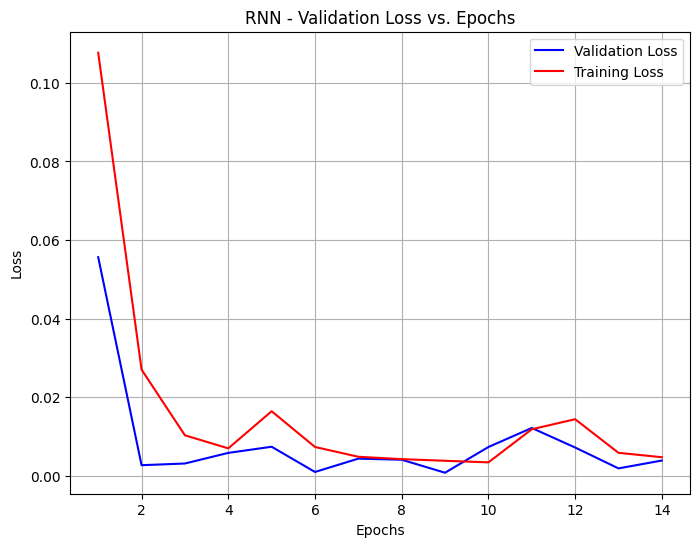

In [22]:
import matplotlib.pyplot as plt

history = final_model.history

# Extract validation loss and training loss from the history
val_loss = history.history['val_loss']
train_loss = history.history['loss']

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='b')
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN - Validation Loss vs. Epochs')
plt.legend()
plt.savefig("/content/drive/MyDrive/HyperTunedNNs/pics/RNN - Validation Loss vs. Epochs.jpg")
plt.grid(True)
plt.show()


In [44]:
final_model.save('RNN_model.keras')

**D. ploting the train and test pred against real valus**

1.making predictions

In [23]:
import numpy as np
# Making the predictions and visualizing the results
# Function to make predictions
def make_predictions(model, train_set, test_set, scaler):

    # Get the predicted average price
    # Make predictions
    train_predict = model.predict(train_set)
    test_predict = model.predict(test_set)

    # Invert predictions to original scale
    train_average_predict = scaler.inverse_transform(np.concatenate((np.zeros((train_predict.shape[0], 3)), train_predict), axis=1))[:, 3]
    test_average_predict = scaler.inverse_transform(np.concatenate((np.zeros((test_predict.shape[0], 3)), test_predict), axis=1))[:, 3]

    #reshaping to a 2d array
    train_average_predict = train_average_predict.reshape(-1, 1)
    test_average_predict = test_average_predict.reshape(-1, 1)

    return train_average_predict, test_average_predict

train_average_predict_RNN , test_average_predict_RNN = make_predictions(final_model, X_train_no_val, X_test, scaler2)

with open('train_average_predict_RNN.pkl', 'wb') as f:
    pkl.dump(train_average_predict_RNN, f)

with open('test_average_predict_RNN.pkl', 'wb') as f:
    pkl.dump(test_average_predict_RNN, f)



78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2.plot the results

Train Score: 0.000028 MSE
Test Score: 0.000016 MSE


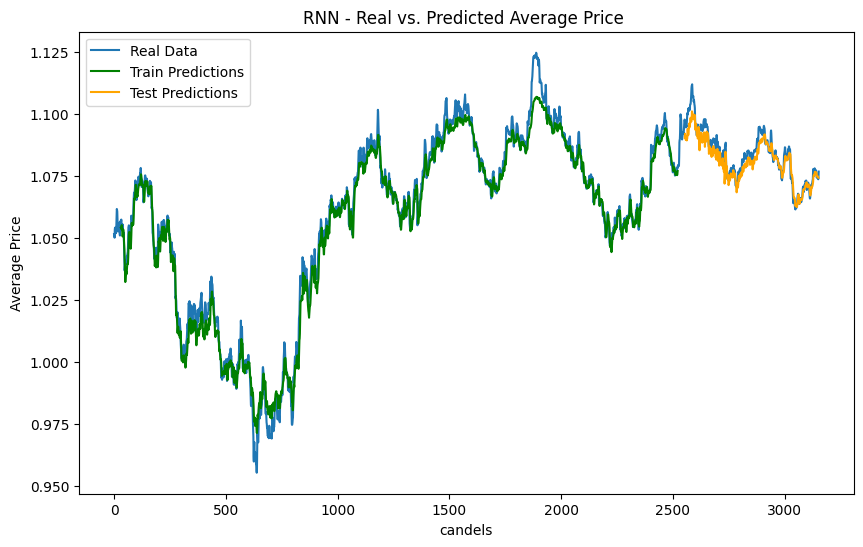

In [25]:
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

#separating the part of the not scaled data for calculating MSE
y_test_pred = real_y_test_all[-len(test_average_predict_RNN): , :]
y_train_pred = real_y_train_all[-len(train_average_predict_RNN): , :]

# Plot MSE
trainScore_RNN = mean_squared_error(y_train_pred, train_average_predict_RNN)
print('Train Score: %.6f MSE' % (trainScore_RNN))
testScore_RNN = mean_squared_error(y_test_pred, test_average_predict_RNN)
print('Test Score: %.6f MSE' % (testScore_RNN))

with open('testScore_RNN.pkl', 'wb') as f:
    pkl.dump(testScore_RNN, f)


#visulizing the train and test pred
time_step = 30
trainPredictPlot = np.empty_like(real_average)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_average_predict_RNN) + time_step, :] = train_average_predict_RNN
testPredictPlot = np.empty_like(real_average)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_average_predict_RNN) + (time_step * 2) + 1 :len(real_average) -1, :] = test_average_predict_RNN

plt.figure(figsize=(10, 6))
plt.plot(real_average,  label='Real Data')
plt.plot(trainPredictPlot, color='green', label='Train Predictions')
plt.plot(testPredictPlot, color='orange', label='Test Predictions')
plt.legend()
plt.xlabel('candels')
plt.ylabel('Average Price')
plt.title('RNN - Real vs. Predicted Average Price ')
plt.savefig("/content/drive/MyDrive/HyperTunedNNs/pics/RNN - Real vs. Predicted Average Price.jpg")
plt.show()


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /tmp/tb_logs

<IPython.core.display.Javascript object>